# Практика

In [1]:
import numpy as np

class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        #### YOUR CODE HERE
        #### Create weights, initialize them with samples from N(0, 0.1).
        self.W = np.random.randn(input_size, output_size)*0.01
        self.b = np.zeros(output_size)

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        self.X = X
        return X.dot(self.W)+self.b

    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        self.dLdW = self.X.T.dot(dLdy)
        self.dLdb = dLdy.sum(0)
        self.dLdx = dLdy.dot(self.W.T)
        return self.dLdx

    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - learning_rate*dLdw
        '''
        self.W = self.W - learning_rate * self.dLdW
        self.b = self.b - learning_rate * self.dLdb

class Sigmoid:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = 1./(1+np.exp(-X))
        return self.s

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return self.s*(1-self.s)*dLdy

    def step(self, learning_rate):
        pass

class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        pass

    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.p = np.exp(X)
        self.p /= self.p.sum(1, keepdims=True)
        self.y = np.zeros((X.shape[0], X.shape[1]))
        self.y[np.arange(X.shape[0]), y] = 1
        return -(np.log(self.p)*self.y).sum(1).mean(0)

    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        return (self.p - self.y) / self.y.shape[0]


class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        self.modules = modules

    def forward(self, X):
        y = X
        for i in range(len(self.modules)):
            y = self.modules[i].forward(y)
        return y

    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        for i in range(len(self.modules))[::-1]:
            dLdy = self.modules[i].backward(dLdy)

    def step(self, learning_rate):
        for i in range(len(self.modules)):
            self.modules[i].step(learning_rate)


# Работа с MNIST

Воспользуемся написанной нейронной сетью для решения задачи распознавания рукописных цифр. Также мы исследуем, как влияет выбор нелинейности и предобработка данных на качество классификации.

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [2]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from IPython.display import clear_output
%matplotlib inline
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise

In [3]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 459kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.76MB/s]


In [4]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

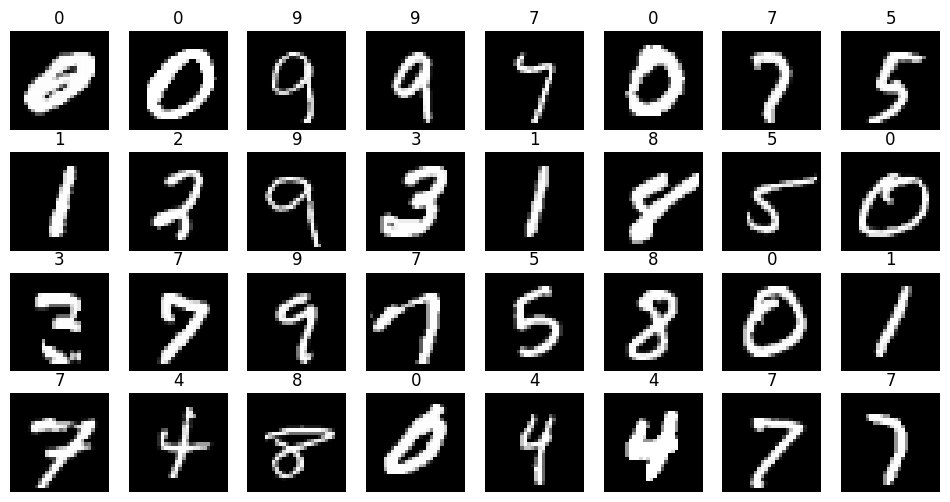

In [5]:
plt.figure(figsize=(12, 6))
for i in range(len(X)):
    plt.subplot(4, 8, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

## Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [6]:
X[0].shape

(1, 28, 28)

In [7]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [8]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.304/0.299	Accuracy: 0.919/0.920

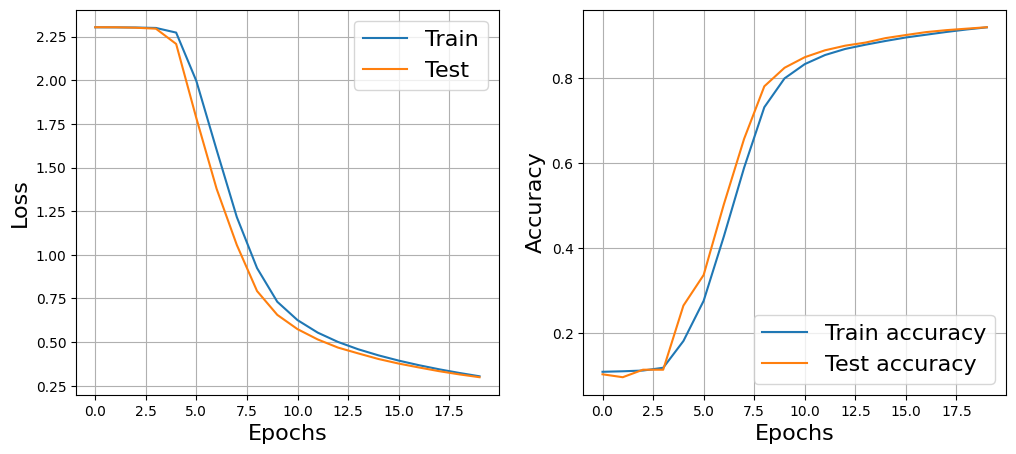

In [9]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности
Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [10]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass


class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''

    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.036/0.076	Accuracy: 0.990/0.978

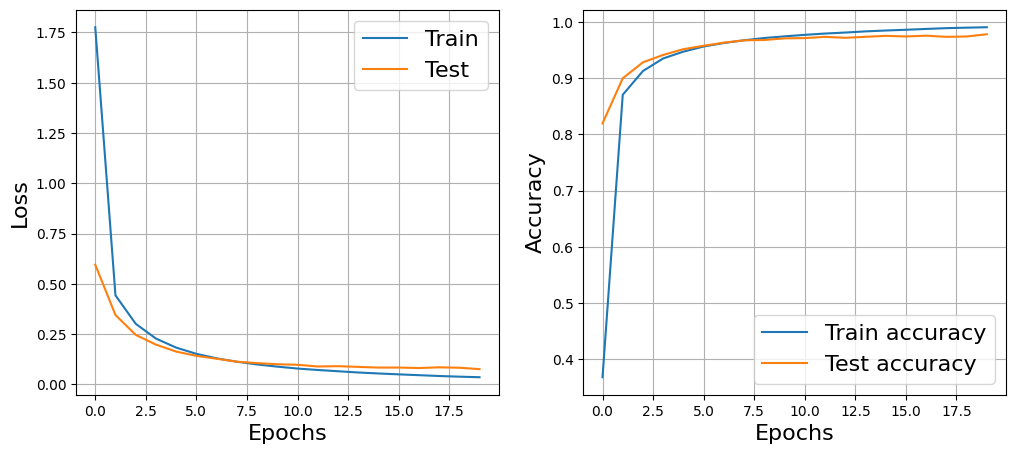

In [11]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.048/0.081	Accuracy: 0.986/0.977

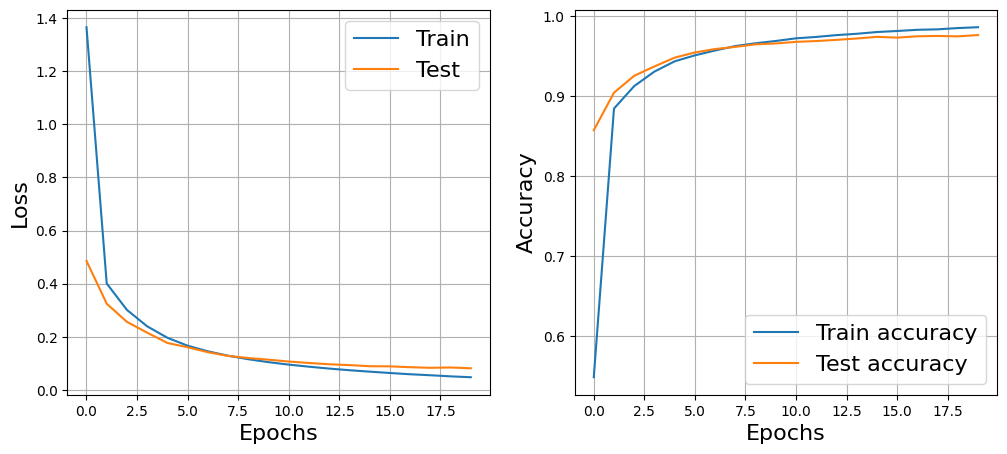

In [12]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

Сравнение результатов

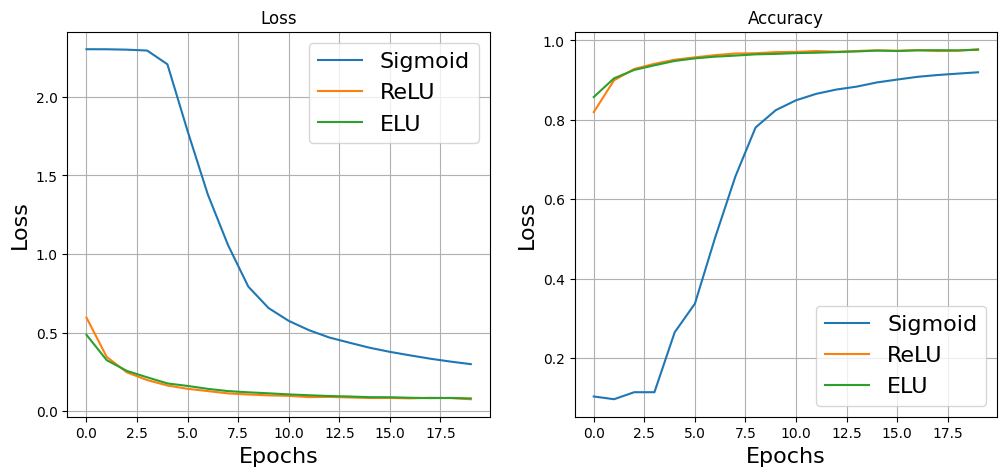

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

# Анализ ошибок

In [14]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

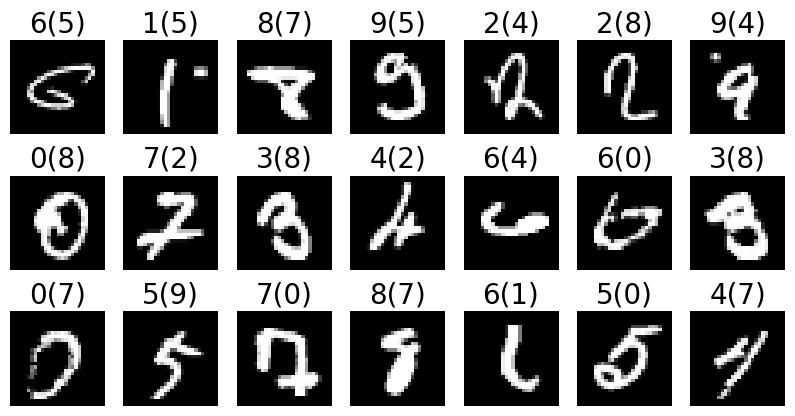

In [15]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

## Задание 1 (1 балл): Реализовать Tanh
Нужно реализовать функцию активации Tanh по аналогии с примерами выше

In [16]:
class Tanh:
    ''' tanh(x) = (exp(x) - exp(-x))/(exp(x) + exp(-x)) '''
    def __init__(self):
        self.X = None

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X.copy()
        return (np.exp(X) - np.exp(-X))/(np.exp(X) + np.exp(-X))

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        dydX = 1/cosh(x)^2 = 4/(exp(X)+ exp(-X))^2
        '''
        dydX = 4 / ((np.exp(self.X) + np.exp(-self.X)) ** 2)
        return dLdy*dydX


    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.031/0.081	Accuracy: 0.994/0.975

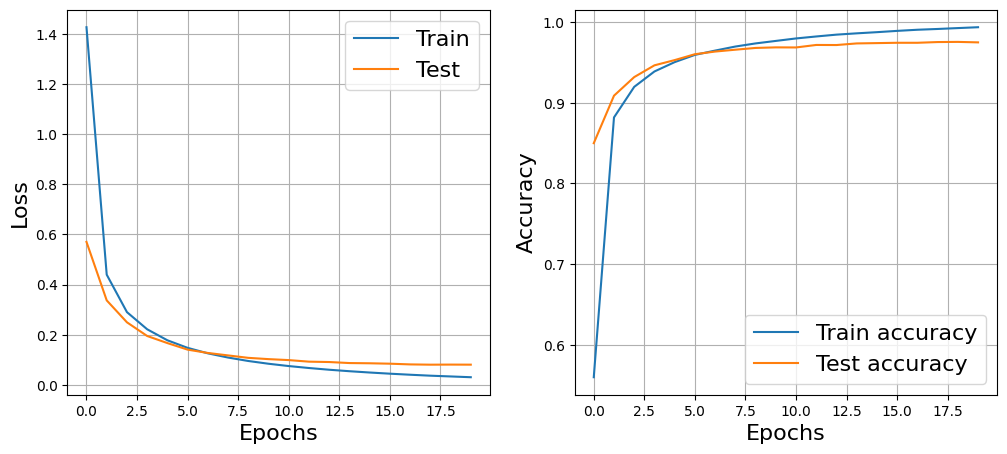

In [17]:
network = NeuralNetwork([Linear(784, 100), Tanh(),
               Linear(100, 100), Tanh(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

## Задание 2 (4 балла): Аугментации
Необходимо реализовать следующие преобразования (пример можно найти в лекции, также допускается использовать готовые варианты, например "from skimage.transform import rotate")
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности? Какие можно сделать выводы? (Сравнивать подходы можно по аналогии с тем, как это было проделано выше)

### Класс аугментаций

In [18]:
class Augmentations:
    @staticmethod
    def rotate_image(image, angle_range=(-10, 10)):
        image_2d = image.reshape(28, 28)
        angle = np.random.uniform(angle_range[0], angle_range[1])
        rotated = rotate(image_2d, angle, mode='edge', preserve_range=True)
        return rotated.flatten()
    
    @staticmethod
    def shift_image(image, max_shift=1):
        image_2d = image.reshape(28, 28)
        shift_x = np.random.randint(-max_shift, max_shift + 1)
        shift_y = np.random.randint(-max_shift, max_shift + 1)
        
        transform = AffineTransform(translation=(shift_x, shift_y))
        shifted = warp(image_2d, transform, mode='edge', preserve_range=True)
        return shifted.flatten()
    @staticmethod
    def add_noise(image, noise_type='gaussian', var=0.05):
        image_2d = image.reshape(28, 28)
        noisy = random_noise(image_2d, mode=noise_type, var=var, clip=True)
        return (noisy * 255).flatten()
    
    @staticmethod
    def apply_all(image):
        augmented = image.copy()
        augmented = Augmentations.rotate_image(augmented)
        augmented = Augmentations.shift_image(augmented)
        augmented = Augmentations.add_noise(augmented)
        return augmented


### Обучение с аугментациями

In [19]:
def train_with_augmentation(network, epochs, learning_rate, augmentation_type=None,
                          plot=True, verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()

                if augmentation_type:
                    X_augmented = []
                    for img in X:
                        if augmentation_type == 'rotate':
                            img_aug = Augmentations.rotate_image(img)
                        elif augmentation_type == 'shift':
                            img_aug = Augmentations.shift_image(img)
                        elif augmentation_type == 'noise':
                            img_aug = Augmentations.add_noise(img)
                        elif augmentation_type == 'all':
                            img_aug = Augmentations.apply_all(img)
                        else:
                            img_aug = img
                        X_augmented.append(img_aug)
                    X = np.array(X_augmented)
                
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            
            losses = []
            accuracies = []
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            
            clear_output(True)
            if verbose:
                aug_type = augmentation_type if augmentation_type else 'none'
                sys.stdout.write(f'\rEpoch {epoch} ({aug_type})... (Train/Test) NLL: {train_loss_epochs[-1]:.3f}/{test_loss_epochs[-1]:.3f}\tAccuracy: {train_accuracy_epochs[-1]:.3f}/{test_accuracy_epochs[-1]:.3f}')
            
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
                
    except KeyboardInterrupt:
        pass
    
    return train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs

### Обучение

In [20]:
results = {}
augmentation_types = [None, 'rotate', 'shift', 'noise', 'all']

Epoch 19 (all)... (Train/Test) NLL: 0.559/0.420	Accuracy: 0.830/0.875

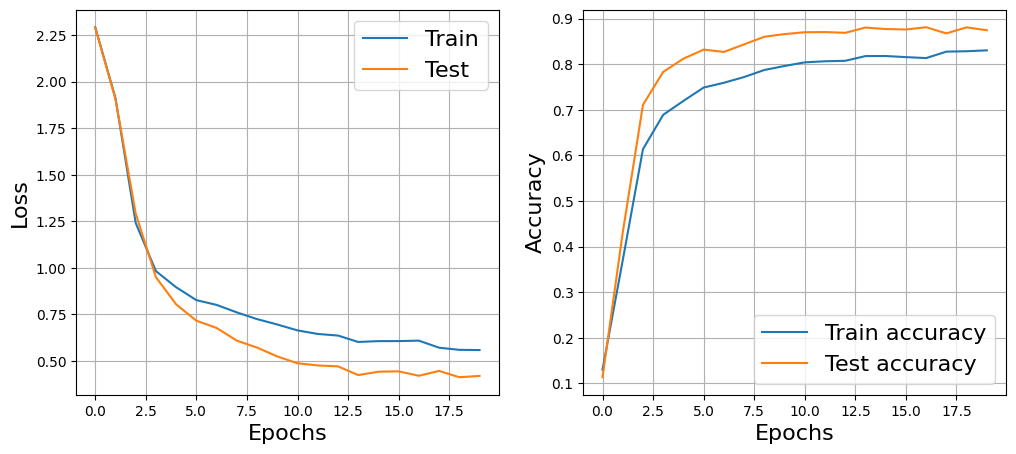

In [21]:
for aug_type in augmentation_types:
    print(f"Training with augmentation type: {aug_type if aug_type else 'none'}")
    
    network = NeuralNetwork([
        Linear(784, 100), Sigmoid(),
        Linear(100, 100), Sigmoid(),
        Linear(100, 10)
    ])
    
    tr_loss, ts_loss, tr_acc, ts_acc = train_with_augmentation(network, 20, 0.01, augmentation_type=aug_type, verbose=True)
    
    results[aug_type if aug_type else 'none'] = {
        'train_loss': tr_loss,
        'test_loss': ts_loss,
        'train_accuracy': tr_acc,
        'test_accuracy': ts_acc,
        'final_test_acc': ts_acc[-1]
    }


### Визуализация

In [22]:
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

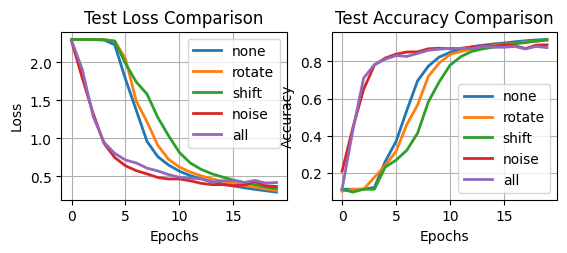

In [23]:
plt.subplot(2, 2, 1)
for aug_type, data in results.items():
    plt.plot(data['test_loss'], label=f'{aug_type}', linewidth=2)
plt.title('Test Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


plt.subplot(2, 2, 2)
for aug_type, data in results.items():
    plt.plot(data['test_accuracy'], label=f'{aug_type}', linewidth=2)
plt.title('Test Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

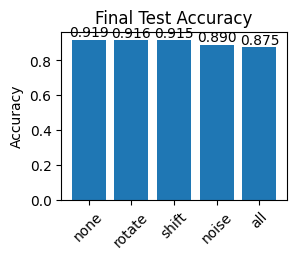

In [24]:
plt.subplot(2, 2, 3)
final_accuracies = [data['final_test_acc'] for data in results.values()]
aug_types = list(results.keys())
bars = plt.bar(aug_types, final_accuracies)
plt.title('Final Test Accuracy')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

for bar, acc in zip(bars, final_accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
            f'{acc:.3f}', ha='center', va='bottom')